In [21]:
!pip install xgboost

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 42

In [55]:
train = pd.read_csv('public_train.csv')
test = pd.read_csv('public_test.csv')

C:\Users\MMarci\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'
df = pd.concat([test, train])

In [57]:
for attr in df.columns:
    if attr == "TARGET":
        pass
    elif df[attr].dtype == 'object':
        df[attr] = df[attr].fillna("nincs_adat")
        #print(attr)
    else:
        #print(np.nanmedian(df[attr]))
        df[attr] = df[attr].fillna(np.nanmean(df[attr]))

In [58]:
bemeno_valtozok = []
for attr in df.columns:
    if df[attr].dtype != 'object':
        bemeno_valtozok.append(attr)

bemeno_valtozok.remove("ID")
bemeno_valtozok.remove("TARGET")

In [59]:
train = df[df['train_or_test'] == "train"]
test = df[df['train_or_test'] == "test"]

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBRegressor

model = XGBRegressor()
n_estimators = [100, 150, 200]
max_depth = [ 3,4,5,6, 7,8,9,10,11,12]
learning_rate = [0.1]
#learning_rate = [0.1, 0.2, 0.3]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth = max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=2)
grid_result = grid_search.fit(train[bemeno_valtozok], train['TARGET'])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.3min finished


Best: 0.741007 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
0.696211 (0.012093) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.701737 (0.011639) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
0.707304 (0.012790) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
0.711171 (0.011294) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.718395 (0.010999) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}
0.723582 (0.011240) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
0.721420 (0.011816) with: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.727976 (0.012743) with: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
0.731888 (0.012451) with: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
0.730491 (0.009155) with: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
0.734896 (0.007978) with: {'learning_rate': 0.1, 'max_depth

In [31]:
model = XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth = 7)
model.fit(train[bemeno_valtozok], train['TARGET'])

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [32]:
test['p1'] = model.predict(test[bemeno_valtozok])

C:\Users\MMarci\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
submission_df = test[['ID', 'p1']].copy()
submission_df.columns=["Id", "Predicted"]
submission_df.to_csv("zfd4kx.csv", index=False)

In [ ]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

predictors = bemeno_valtozok
target= "TARGET"

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    cvresult=None
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print("\nModel Report")
    print("Best num_boost_round: %.4g" % cvresult.shape[0])
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predictions))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[285]	train-auc:0.91322+0.00139	test-auc:0.73320+0.00602
[286]	train-auc:0.91343+0.00137	test-auc:0.73321+0.00596
[287]	train-auc:0.91369+0.00135	test-auc:0.73325+0.00597
[288]	train-auc:0.91390+0.00127	test-auc:0.73331+0.00601
[289]	train-auc:0.91420+0.00133	test-auc:0.73325+0.00592
[290]	train-auc:0.91451+0.00128	test-auc:0.73317+0.00603
[291]	train-auc:0.91481+0.00129	test-auc:0.73310+0.00592
[292]	train-auc:0.91507+0.00121	test-auc:0.73304+0.00594
[293]	train-auc:0.91533+0.00127	test-auc:0.73298+0.00599

Model Report
AUC Score (Train): 0.882389


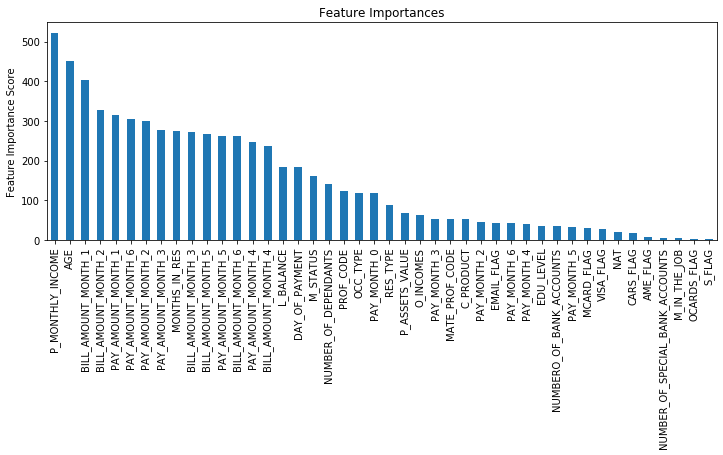

In [67]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=RANDOM_SEED)

modelfit(xgb1, train, predictors)

In [68]:
xgb1 #n_estimators 245

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=245, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [69]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
max_depth': 7, 'min_child_weight': 5
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=245, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=RANDOM_SEED), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\MMarci\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [76]:
param_test2 = {
 'max_depth':[6,7,8], #7
 'min_child_weight':[4,5,6] #5
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=245, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=RANDOM_SEED), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([31.11053052, 32.99270682, 36.75915079, 49.18671966, 47.86508007,
         42.35317202, 48.66508918, 46.05209947, 36.12419162]),
  'std_fit_time': array([0.4453242 , 1.15363589, 2.13963855, 0.73029332, 1.10214155,
         2.81038621, 0.58375675, 0.44069928, 9.19287405]),
  'mean_score_time': array([0.06936035, 0.08358207, 0.11040969, 0.07936764, 0.08781495,
         0.07355881, 0.08487992, 0.0831974 , 0.06959505]),
  'std_score_time': array([0.01455967, 0.01229425, 0.0239447 , 0.009885  , 0.01166711,
         0.01077521, 0.00462779, 0.01481959, 0.01719682]),
  'param_max_depth': masked_array(data=[6, 6, 6, 7, 7, 7, 8, 8, 8],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [ ]:
param_test2b = {
 'min_child_weight':[6,7,8,9] #6
}

gsearch2b = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=245, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=RANDOM_SEED), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [81]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)] # 0.3
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=245, max_depth=7,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=RANDOM_SEED), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [82]:
gsearch3.best_params_

{'gamma': 0.3}

[0]	train-auc:0.69615+0.00301	test-auc:0.66565+0.00216
[1]	train-auc:0.71502+0.00348	test-auc:0.67854+0.00505
[2]	train-auc:0.72579+0.00377	test-auc:0.68714+0.00780
[3]	train-auc:0.73352+0.00456	test-auc:0.69279+0.00778
[4]	train-auc:0.73985+0.00288	test-auc:0.69773+0.00736
[5]	train-auc:0.74329+0.00308	test-auc:0.69965+0.00627
[6]	train-auc:0.74758+0.00338	test-auc:0.70098+0.00665
[7]	train-auc:0.75057+0.00331	test-auc:0.70184+0.00706
[8]	train-auc:0.75507+0.00487	test-auc:0.70266+0.00736
[9]	train-auc:0.75900+0.00463	test-auc:0.70367+0.00655
[10]	train-auc:0.76280+0.00435	test-auc:0.70518+0.00705
[11]	train-auc:0.76715+0.00400	test-auc:0.70755+0.00661
[12]	train-auc:0.77018+0.00403	test-auc:0.70809+0.00613
[13]	train-auc:0.77325+0.00363	test-auc:0.70873+0.00629
[14]	train-auc:0.77647+0.00442	test-auc:0.70955+0.00641
[15]	train-auc:0.77949+0.00419	test-auc:0.71066+0.00611
[16]	train-auc:0.78251+0.00436	test-auc:0.71128+0.00644
[17]	train-auc:0.78507+0.00400	test-auc:0.71182+0.00678
[1

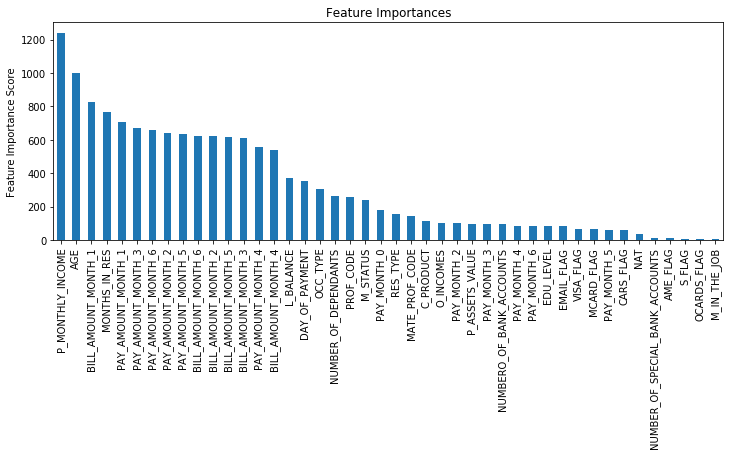

In [85]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=6,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=RANDOM_SEED)
modelfit(xgb2, train, predictors)

In [86]:
xgb2 # n_estimators 238

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=238, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [88]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)], # 0.9
 'colsample_bytree':[i/10.0 for i in range(6,10)] # 0.8
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=238, max_depth=7,
 min_child_weight=6, gamma=0.3, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=RANDOM_SEED), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\MMarci\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


AttributeError: 'GridSearchCV' object has no attribute 'cv_results'

In [93]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)], #0.9
 'colsample_bytree':[i/100.0 for i in range(75,90,5)] #0.8
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=238, max_depth=7,
 min_child_weight=6, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
  nthread=4, scale_pos_weight=1,seed=RANDOM_SEED), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

C:\Users\MMarci\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([35.79657221, 31.42652669, 30.92153335, 36.71262536, 34.53759499,
         32.16400981, 36.07999563, 37.79084716, 34.32615294]),
  'std_fit_time': array([ 2.04136126,  0.2812369 ,  0.43921677,  2.05814798,  1.13250454,
          0.28029942,  1.78352571,  1.14646916, 10.03626941]),
  'mean_score_time': array([0.07575245, 0.06756105, 0.07415757, 0.07675667, 0.06656237,
         0.0671618 , 0.07860527, 0.07395816, 0.06794538]),
  'std_score_time': array([0.01816234, 0.00874878, 0.02022125, 0.00817842, 0.0085883 ,
         0.00705048, 0.0212928 , 0.01370369, 0.01328207]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.85, 0.9, 0.95, 0.85, 0.9, 0.95, 0.85, 0.9, 0.95],
               mask=[False, False, False, False, 

In [97]:
param_test6 = {
 #'reg_alpha':[1e-6,1e-7, 2e-5 ,1e-5, 1e-4,, 0.00005, 0.0002, 0.0002, 0.1, 1, 100]
    'reg_alpha':[i/100000.0 for i in range(10,50,5)] # 'reg_alpha': 0.00035
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=238, max_depth=7,
 min_child_weight=6, gamma=0.3, subsample=0.9, colsample_bytree=0.8,
  nthread=4, scale_pos_weight=1,seed=RANDOM_SEED), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([38.13028588, 43.68550653, 37.33262644, 34.07385783, 34.06711855,
         33.6068974 , 33.8242661 , 33.8351737 ]),
  'std_fit_time': array([3.74685589, 2.67211653, 2.11546828, 0.47942602, 0.30590386,
         0.33641971, 0.46407587, 0.41120193]),
  'mean_score_time': array([0.08220482, 0.09019575, 0.06777678, 0.07265949, 0.06836095,
         0.06956038, 0.08025694, 0.0625649 ]),
  'std_score_time': array([0.0068463 , 0.03722507, 0.00517944, 0.00642665, 0.00791014,
         0.00972294, 0.01382705, 0.01200339]),
  'param_reg_alpha': masked_array(data=[0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035,
                     0.0004, 0.00045],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.0001},
   {'reg_alpha': 0.00015},
   {'reg_alpha': 0.0002},
   {'reg_alpha': 0.00025},
   {'reg_alpha': 0.0003},
   {'reg_alpha': 0.00035},
   {'reg_alpha': 0.0004},
 

In [ ]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=6,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.00035,
 nthread=4,
 scale_pos_weight=1,
 seed=RANDOM_SEED)

modelfit(xgb3, train, predictors)

In [100]:
xgb3

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=144, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.00035,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.9,
             tree_method=None, validate_parameters=False, verbosity=None)

[0]	train-auc:0.69765+0.00253	test-auc:0.67158+0.00611
[1]	train-auc:0.71226+0.00383	test-auc:0.68237+0.00611
[2]	train-auc:0.72113+0.00205	test-auc:0.68739+0.00447
[3]	train-auc:0.72785+0.00486	test-auc:0.69395+0.00742
[4]	train-auc:0.73191+0.00260	test-auc:0.69665+0.00624
[5]	train-auc:0.73316+0.00207	test-auc:0.69686+0.00762
[6]	train-auc:0.73402+0.00120	test-auc:0.69718+0.00696
[7]	train-auc:0.73434+0.00229	test-auc:0.69695+0.00686
[8]	train-auc:0.73635+0.00192	test-auc:0.69822+0.00688
[9]	train-auc:0.73698+0.00171	test-auc:0.69888+0.00615
[10]	train-auc:0.73865+0.00143	test-auc:0.70019+0.00641
[11]	train-auc:0.74069+0.00179	test-auc:0.70087+0.00564
[12]	train-auc:0.74153+0.00140	test-auc:0.70150+0.00620
[13]	train-auc:0.74171+0.00162	test-auc:0.70126+0.00658
[14]	train-auc:0.74251+0.00219	test-auc:0.70192+0.00655
[15]	train-auc:0.74218+0.00177	test-auc:0.70170+0.00640
[16]	train-auc:0.74252+0.00170	test-auc:0.70183+0.00664
[17]	train-auc:0.74247+0.00155	test-auc:0.70166+0.00659
[1

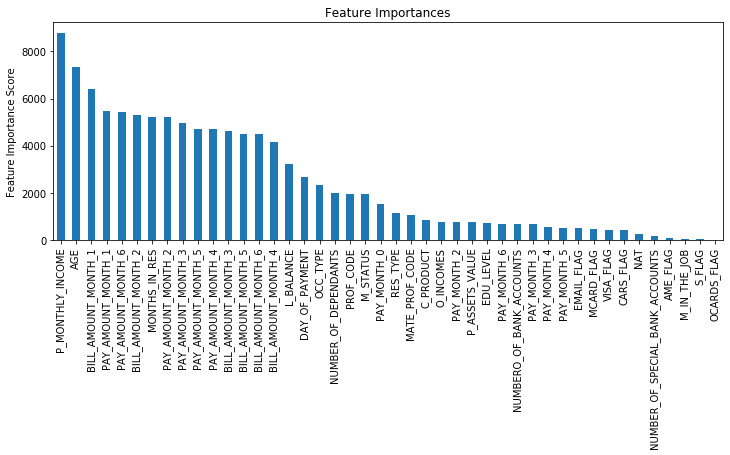

In [103]:
xgb4 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=6,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.00035,
 nthread=4,
 scale_pos_weight=1,
 seed=RANDOM_SEED)
modelfit(xgb4, train, predictors)

In [118]:
xgb4 # 1815 estimators

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=1921, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0.00035,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.9,
              tree_method=None, validate_parameters=False, verbosity=None)

In [115]:
test['p1'] = xgb4.predict_proba(test[bemeno_valtozok])
submission_df = test[['ID', 'p1']].copy()
submission_df.columns=["Id", "Predicted"]
submission_df.to_csv("zfd4kx.csv", index=False)

C:\Users\MMarci\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\MMarci\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
